# Descriptive Analysis on SATP Data

In [2]:
# Import data analysis and NLP packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import gensim
import multiprocessing

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#!pip install --upgrade pip
#!pip install --upgrade Pillow
#!pip install --upgrade gensim

#Filepaths
home = "../"
data = home + "data/"

In this notebook, I generate descriptive statistics on the SATP dataset to identify topics and themes that can inform further machine learning.

## Preprocessing

In [3]:
# Original dataset
satp = pd.read_csv(data + 'dataset_satp_2019.csv')
satp.head()

,description,year
0,"A Special Police Officer (SPO), identified as ...",2019.0
1,Armed Forces Special Powers Act (AFSPA) has be...,2019.0
2,"On January 1, an ex-United Liberation Front of...",2019.0
3,The number of objections filed on the draft of...,2019.0
4,The Year 2019 will be challenging for the Odis...,2019.0


In [19]:
# Define function for string cleaning + lemmatizing
def nlp_pipeline(data):
    # Convert to lower case
    data['description'] = data['description'].str.lower()
    # Remove duplicate values
    data = data.drop_duplicates().reset_index(drop=True)
    row_lst = []
    lem = WordNetLemmatizer()
    stop = stopwords.words('english')
    for i in range(len(data)):
        row = data['description'].iloc[i]
        # Remove non-alphanumeric characters
        row = re.sub(r'[^0-9A-Za-z]', ' ', row)
        # Remove stopwords and lemmatizing
        row = ' '.join([lem.lemmatize(word) for word in row.split() if not word in set(stopwords.words('english'))])
        row_lst.append(row)
    data['description'] = row_lst
    return data

In [16]:
' '.join(['a', 'b'])

'a b'

In [20]:
# Create the cleaned SATP dataset
cleaned_satp = nlp_pipeline(satp)
cleaned_satp.head()

,description,year
0,special police officer spo identified sameer a...,2019.0
1,armed force special power act afspa extended s...,2019.0
2,january 1 ex united liberation front asom ulfa...,2019.0
3,number objection filed draft national register...,2019.0
4,year 2019 challenging odisha police many impor...,2019.0


In [6]:
# Add a lengths column
length = cleaned_satp['description'].apply(len)
cleaned_satp['length'] = length
cleaned_satp.head()

,description,year,length
0,special police officer spo identified sameer a...,2019.0,370
1,armed force special power act afspa extended s...,2019.0,480
2,january 1 ex united liberation front asom ulfa...,2019.0,411
3,number objection filed draft national register...,2019.0,448
4,year 2019 challenging odisha police many impor...,2019.0,341


## Descriptive Analysis

### 1. Distribution of Length

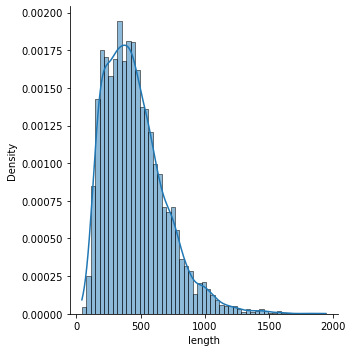

In [7]:
sns.displot(cleaned_satp['length'], kde=True, stat='density')
plt.show()

### 2. Wordcloud

Here I generate a wordcloud to identify which words occur the most often.

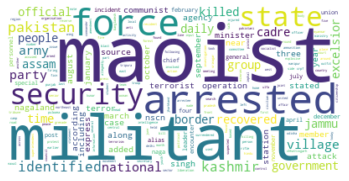

In [8]:
# Create a list of words that are not meaningful in this context to remove from the text (not removed in previous steps)
words_to_remove = ['said', 'report', 'district', 'india', 'indian', 'police', 'area']
# Process the text to plot on the wordcloud
text = ''
for i in range(len(cleaned_satp)):
    text = text + ' ' + cleaned_satp['description'][i]
for word in words_to_remove:
    text = re.sub(word, ' ', text)
# Plot the wordcloud
word_cloud = WordCloud(collocations=False, background_color='white', min_word_length=4).generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

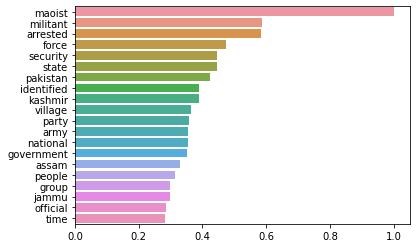

In [9]:
# Relative frequencies of words
rel_freq = word_cloud.words_
n = 20
sns.barplot(y=list(rel_freq.keys())[:n], x=list(rel_freq.values())[:n])
plt.show()

In [10]:
rel_freq

{'maoist': 1.0,
 'militant': 0.5880597014925373,
 'arrested': 0.5832835820895522,
 'force': 0.47432835820895525,
 'security': 0.44597014925373135,
 'state': 0.4444776119402985,
 'pakistan': 0.4223880597014925,
 'identified': 0.38925373134328356,
 'kashmir': 0.388955223880597,
 'village': 0.3635820895522388,
 'party': 0.35880597014925375,
 'army': 0.35522388059701493,
 'national': 0.35313432835820896,
 'government': 0.35074626865671643,
 'assam': 0.32865671641791044,
 'people': 0.31283582089552237,
 'group': 0.29940298507462687,
 'jammu': 0.2991044776119403,
 'official': 0.2847761194029851,
 'time': 0.2835820895522388,
 'cadre': 0.282089552238806,
 'daily': 0.2817910447761194,
 'killed': 0.2665671641791045,
 'recovered': 0.2644776119402985,
 'border': 0.2644776119402985,
 'excelsior': 0.2632835820895522,
 'operation': 0.2594029850746269,
 'stated': 0.24895522388059702,
 'three': 0.24865671641791046,
 'case': 0.23373134328358208,
 'nagaland': 0.23134328358208955,
 'communist': 0.23104477

### 3. N-Grams

Here I generate and plot 2-gram, 3-gram and 4-gram to identify which words occur together the most often.

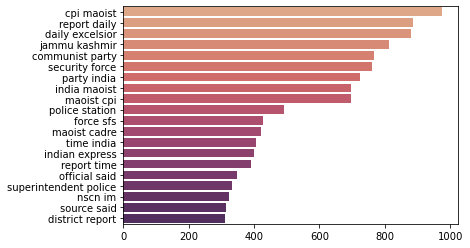

In [21]:
# Process data
ngram_text = list(cleaned_satp['description'])

# Define function for generating and plotting the ngrams
def generate_ngrams(text, n, top_n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    sns.barplot(y=[i[0] for i in words_freq][:top_n], x=[i[1] for i in words_freq][:top_n], palette='flare')
    plt.show()
    return words_freq

# Bigram
ngram_2 = generate_ngrams(ngram_text, 2, 20)

In [12]:
ngram_2[:20]

[('cpi maoist', 976),
 ('report daily', 885),
 ('daily excelsior', 879),
 ('jammu kashmir', 812),
 ('communist party', 767),
 ('security force', 760),
 ('party india', 723),
 ('india maoist', 698),
 ('maoist cpi', 697),
 ('police station', 492),
 ('force sfs', 426),
 ('maoist cadre', 420),
 ('time india', 406),
 ('indian express', 399),
 ('report time', 390),
 ('official said', 348),
 ('superintendent police', 332),
 ('nscn im', 323),
 ('source said', 313),
 ('district report', 310)]

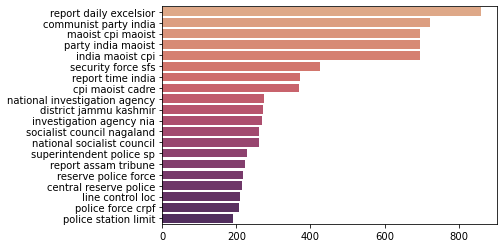

In [22]:
# Trigram
ngram_3 = generate_ngrams(ngram_text, 3, 20)

In [14]:
ngram_3[:20]

[('report daily excelsior', 861),
 ('communist party india', 723),
 ('maoist cpi maoist', 697),
 ('party india maoist', 696),
 ('india maoist cpi', 696),
 ('security force sfs', 426),
 ('report time india', 372),
 ('cpi maoist cadre', 370),
 ('national investigation agency', 274),
 ('district jammu kashmir', 273),
 ('investigation agency nia', 269),
 ('socialist council nagaland', 262),
 ('national socialist council', 261),
 ('superintendent police sp', 228),
 ('report assam tribune', 222),
 ('reserve police force', 217),
 ('central reserve police', 216),
 ('line control loc', 210),
 ('police force crpf', 206),
 ('police station limit', 192)]

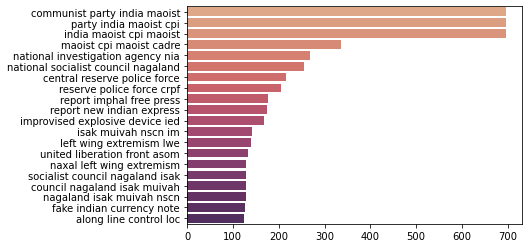

In [23]:
# 4-gram
ngrams_4 = generate_ngrams(ngram_text, 4, 20)

In [16]:
ngrams_4[:20]

[('communist party india maoist', 696),
 ('party india maoist cpi', 696),
 ('india maoist cpi maoist', 696),
 ('maoist cpi maoist cadre', 335),
 ('national investigation agency nia', 268),
 ('national socialist council nagaland', 256),
 ('central reserve police force', 216),
 ('reserve police force crpf', 205),
 ('report imphal free press', 177),
 ('report new indian express', 175),
 ('improvised explosive device ied', 169),
 ('isak muivah nscn im', 142),
 ('left wing extremism lwe', 139),
 ('united liberation front asom', 132),
 ('naxal left wing extremism', 128),
 ('socialist council nagaland isak', 128),
 ('council nagaland isak muivah', 128),
 ('nagaland isak muivah nscn', 128),
 ('fake indian currency note', 127),
 ('along line control loc', 125)]

- remove meaningless words/phrases
- remove words/phrases based on TFIDF vectorization

### 4. Word Embeddings

Here I visualize words in a vector space to identify clusters of words that have similar meaning. Code is adapted from [this article](https://habr.com/en/companies/vk/articles/449984/).

In [17]:
# Prepare the data
train = [text.split() for text in cleaned_satp['description']]
# Count the number of cores - how fast to train the model
cores = multiprocessing.cpu_count()
# Initialize the model
w2v_model = gensim.models.Word2Vec(train, workers=cores)

In [42]:
# Generate clusters of similar words and their simliarities for a random sample of 10 words
sample = np.random.choice(np.array(text.split()), 10)
embedding_clusters = []
word_clusters = []
for word in sample:
    try:
        embeddings = []
        words = []
        for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(w2v_model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    except:
        pass

In [43]:
# Dimensionality reduction using TSNE
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

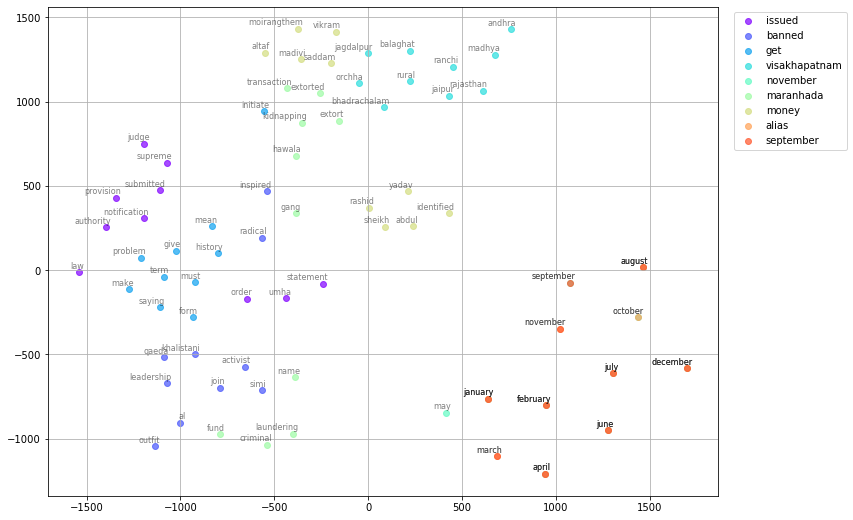

In [52]:
# Plotting the clusters
from sklearn.manifold import TSNE
import matplotlib.cm as cm
%matplotlib inline

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(12, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(sample, embeddings_en_2d, word_clusters)

- can vary parameters